In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import subspace_angles
from sklearn.decomposition import PCA


def generate_data(n_inliers, n_outliers, d):
    """
    Generates a synthetic dataset with inliers and outliers,
    embedded in a space of dimension D = d + 1, and returns the normalized data.
    
    Parameters:
    -----------
    n_inliers : int
        Number of inlier points.
    n_outliers : int
        Number of outlier points.
    d : int
        Intrinsic dimensionality of the inlier data.
        
    Returns:
    --------
    data_normalized : np.ndarray
        The concatenated dataset (inliers and outliers) after normalization.
        Shape: (n_inliers + n_outliers, d+1)
    """
    
    
    D = d + 1

    
    A = np.random.randn(D, D)
    A1 = np.random.randn(D, D)
    Q, _ = np.linalg.qr(A)
    #Q = np.eye(D)
    Q1, _ = np.linalg.qr(A1)

    
    P_inlier = Q[:, :d]  # shape: (D, d)
    P_outlier = Q1[:, d]  # shape: (D,)

   
    inliers = np.random.randn(n_inliers, d)
    inliers_embedded = inliers @ P_inlier.T

    
    outliers = np.random.randn(n_outliers, 1)
    noise = np.random.randn(n_outliers,1)
    outliers = outliers + 0*noise
    outliers_embedded = outliers * P_outlier.reshape(1, -1)

    
    data = np.concatenate([inliers_embedded, outliers_embedded], axis=0)

    
    norms = np.linalg.norm(data, axis=1, keepdims=True)
    data_normalized = data / norms


def generate_data2(n_inliers=100, n_outliers=20, d=3):
   
    D = 2*d                             


    Q, _      = np.linalg.qr(np.random.randn(D, D))
    P_inlier  = Q[:, :d]                   # (D, d)
    P_orth    = Q[:, d:]                   # (D, D-d)

    inliers = np.random.randn(n_inliers, d) @ P_inlier.T      

    cov      = np.random.randn(D, D)                           
    outliers = np.random.randn(n_outliers, D) @ cov.T         

    data = np.vstack([inliers, outliers])                     


    norms = np.linalg.norm(data, axis=1, keepdims=True)
    data  = data / norms

    return data, P_inlier, P_orth

In [2]:


def FMS(X, dd):
    D, N = X.shape

    # Initial iteration count
    iter = 1

    # Perform SVD and initialize L
    U, _, _ = np.linalg.svd(X, full_matrices=False)
    L = U[:, :dd]

    # Set initial angle and tolerance
    ang = 1
    max_iter = 200
    #while ang > 1e-12 and iter < 1000:
    for iter_count in range(1, max_iter + 1):
        Lold = L

        # Compute the residual projection
        temp = (np.eye(D) - L @ L.T) @ X
        w = np.sqrt(np.sum(temp**2, axis=0)) + 1e-10  #regularization max{mu, ...}, small,large,dynamic smoothing
 
        # Reweight and update XX
        XX = X @ np.diag(1.0 / w) @ X.T

        # Perform SVD again on the weighted matrix XX
        U, _, _ = np.linalg.svd(XX, full_matrices=False)
        L = U[:, :dd]

        # Compute the angle between new and old subspace
        ang = np.linalg.norm(subspace_angles(L, Lold))

        iter += 1

    return L

def m_estimator(X):
    N, D = X.shape
    initcov = np.eye(D)  
    oldcov = initcov - 1
    cov = initcov
    iter_count = 1
    eps = 1e-10 
    max_iter = 200 

    #while np.linalg.norm(oldcov - cov, 'fro') > 1e-12 and iter_count < 1000:
    for iter_count in range(1, max_iter + 1):
        temp = X @ np.linalg.inv(cov + eps * np.eye(D))  
        d = np.sum(temp * np.conjugate(X), axis=1)  
        oldcov = cov

       
        temp = (np.real(d) + eps * np.ones(N))**(-1)  
 
        cov = (X.T * temp) @ X / N * D
        cov = cov / np.trace(cov)  
        iter_count += 1  

    return cov


def my_RANSAC(X, d, tau, maxit):
    """
    Runs a RANSAC-like procedure to select an orthonormal basis Ustar that 
    minimizes projection error on a subset of points in X.

    Parameters:
    -----------
    X : numpy.ndarray
        Data matrix of shape (N, D), where each row is a data point.
    d : int
        Dimensionality of the inlier subspace.
    tau : float
        Threshold used to count a point as an inlier (distance below tau).
    maxit : int
        Number of iterations to run RANSAC.

    Returns:
    --------
    Ustar : numpy.ndarray
        Orthonormal basis for the best inlier subspace found (shape (D, d)).
    max_con_num : int
        The maximum number of inliers found.
    """

    N, D = X.shape
    max_con_num = 1
    
    Q, _ = np.linalg.qr(np.random.randn(D, d))
    Ustar = Q

   
    for iter_idx in range(maxit):
        
        indices = np.random.choice(N, d, replace=False)
        
        candidate = X[indices, :].T
        Q_candidate, _ = np.linalg.qr(candidate)
        U = Q_candidate  

        residual = X - (X @ U) @ U.T
        
        dists = np.sqrt(np.sum(residual**2, axis=1))
        
        con_num = np.sum(dists < tau)

        
        if con_num > max_con_num:
            Ustar = U
            max_con_num = con_num

    return Ustar, max_con_num

#add PCA

d=3
data,P_true = generate_data(n_inliers=100, n_outliers=20, d=3)
#PCA
pca = PCA(n_components=3)
pca.fit_transform(data)
P_PCA = np.array(pca.components_).T
#FMS
P_FMS = FMS(data.T,3)
#TME
cov = m_estimator(data)
U, S, VT = np.linalg.svd(data, full_matrices=False)
P_TME = VT[:d].T 
#RANSAC
P_RAN,_ = my_RANSAC(data,d,tau= 1e-7,maxit=500)

error1 = np.linalg.norm(P_PCA@P_PCA.T-P_true@P_true.T)
error2 = np.linalg.norm(P_FMS@P_FMS.T-P_true@P_true.T)
error3 = np.linalg.norm(P_TME@P_TME.T-P_true@P_true.T)
error4 = np.linalg.norm(P_RAN@P_RAN.T-P_true@P_true.T)

repeats = 100 
num1 = 100 #number of inliers
num2 = 30 # number of outliers
d = 3


errors_PCA = []
errors_FMS = []
errors_TME = []
errors_RANSAC = []

for trial in range(repeats):
    
    data, P_true = generate_data(n_inliers=num1, n_outliers=num2, d=d)
    
    #PCA
    pca = PCA(n_components=d)
    pca.fit_transform(data)
    P_PCA = np.array(pca.components_).T  # Transpose so that P_PCA is (D, d)
    
    #FMS
    P_FMS = FMS(data.T, d)  # Assume FMS returns a (D, d) matrix
    
    #TME
    cov = m_estimator(data)
    U, S, VT = np.linalg.svd(data, full_matrices=False)
    P_TME = VT[:d].T
    
    #RANSAC
    P_RAN, _ = my_RANSAC(data, d, tau=1e-7, maxit=500)
    

    error_PCA    = np.linalg.norm(P_PCA @ P_PCA.T - P_true @ P_true.T)
    error_FMS    = np.linalg.norm(P_FMS @ P_FMS.T - P_true @ P_true.T)
    error_TME    = np.linalg.norm(P_TME @ P_TME.T - P_true @ P_true.T)
    error_RANSAC = np.linalg.norm(P_RAN @ P_RAN.T - P_true @ P_true.T)
    
    errors_PCA.append(error_PCA)
    errors_FMS.append(error_FMS)
    errors_TME.append(error_TME)
    errors_RANSAC.append(error_RANSAC)


avg_PCA    = np.mean(errors_PCA)
avg_FMS    = np.mean(errors_FMS)
avg_TME    = np.mean(errors_TME)
avg_RANSAC = np.mean(errors_RANSAC)

print("Average PCA error:",    avg_PCA)
print("Average FMS error:",    avg_FMS)
print("Average TME error:",    avg_TME)
print("Average RANSAC error:", avg_RANSAC)

In [3]:
repeats = 100
num_inliers = 100  # Fixed number of inliers
d = 30


outlier_counts = np.linspace(30,240,21,dtype=int)
outlier_pcts = outlier_counts / (num_inliers + outlier_counts) * 100
results = {}

for num_outliers in outlier_counts:
    
    errors_PCA = []
    errors_FMS = []
    errors_TME = []
    errors_RANSAC = []
    
    for trial in range(repeats):
        # Generate data with a fixed number of inliers and varying number of outliers
        data, P_true,_ = generate_data2(n_inliers=num_inliers, n_outliers=num_outliers, d=d)
        
        # PCA
        pca = PCA(n_components=d)
        pca.fit_transform(data)
        P_PCA = np.array(pca.components_).T  
        
        # FMS 
        P_FMS = FMS(data.T, d)  
        
        # TME
        cov = m_estimator(data)
        U, S, VT = np.linalg.svd(cov, full_matrices=False)
        P_TME = VT[:d].T
        
        # RANSAC estimation
        P_RAN, _ = my_RANSAC(data, d, tau=1e-7, maxit=200)
        
        
        error_PCA    = np.linalg.norm(P_PCA @ P_PCA.T - P_true @ P_true.T)
        error_FMS    = np.linalg.norm(P_FMS @ P_FMS.T - P_true @ P_true.T)
        error_TME    = np.linalg.norm(P_TME @ P_TME.T - P_true @ P_true.T)
        error_RANSAC = np.linalg.norm(P_RAN @ P_RAN.T - P_true @ P_true.T)
        
        errors_PCA.append(error_PCA)
        errors_FMS.append(error_FMS)
        errors_TME.append(error_TME)
        errors_RANSAC.append(error_RANSAC)
    
    # Compute average errors for the current outlier count
    avg_PCA    = np.mean(errors_PCA)
    avg_FMS    = np.mean(errors_FMS)
    avg_TME    = np.mean(errors_TME)
    avg_RANSAC = np.mean(errors_RANSAC)
    
    # Store the average errors in the results dictionary
    results[num_outliers] = {
        "avg_PCA": avg_PCA,
        "avg_FMS": avg_FMS,
        "avg_TME": avg_TME,
        "avg_RANSAC": avg_RANSAC
    }

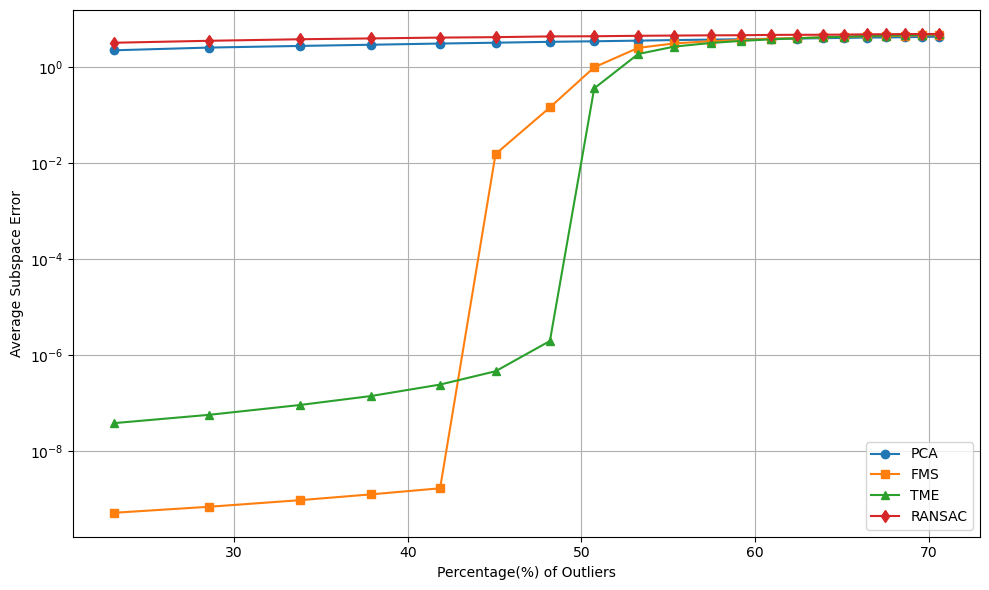

In [4]:
# plot for different number of outliers the accuracy vs ratio(outliers/total)
num_outliers = sorted(results.keys())

avg_PCA    = [results[k]["avg_PCA"] for k in num_outliers]
avg_FMS    = [results[k]["avg_FMS"] for k in num_outliers]
avg_TME    = [results[k]["avg_TME"] for k in num_outliers]
avg_RANSAC = [results[k]["avg_RANSAC"] for k in num_outliers]

# Create a plot
plt.figure(figsize=(10, 6))

# Plot each method's error vs. number of outliers
plt.plot(outlier_pcts, avg_PCA, marker='o', label='PCA')
plt.plot(outlier_pcts, avg_FMS, marker='s', label='FMS')
plt.plot(outlier_pcts, avg_TME, marker='^', label='TME')
plt.plot(outlier_pcts, avg_RANSAC, marker='d', label='RANSAC')

# Add labels and title
plt.xlabel('Percentage(%) of Outliers')
plt.ylabel('Average Subspace Error')
plt.yscale("log")
#plt.title('Performance of Subspace Recovery Methods vs. Number of Outliers')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.savefig('exp1_fixiter(d=30,D=2d).png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()
# D = 2*d, D = 3*d